<a href="https://colab.research.google.com/github/swapnamoy007/ML-ASSIGNMENT/blob/main/Module_7/MidTerm_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MidTerm - 2 for the Fall 2024 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering.

- Instructor Sergei V. Kalinin

Special point:
- ChatGPT will augment your power as a coder
- If and only if you know what you want to accomplish!

# 1.Out-of-distribution effects

Explore the out of distribution effects in VAE.
- Build the VAE or AE denoiser
- Train it on the digits [0-5]
- Quantufy performance on the digits that it was trained on (e.g. vis SSID of ground truth vs reconstruction as a function of noise)
- Quantify performance for digits [6-9]

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from skimage.metrics import structural_similarity as ssim
import numpy as np

# 1. Define the Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Define encoder and decoder layers
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 28*28), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


# 2. Prepare Data
def load_data(digits):
    transform = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1)])
    full_data = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
    data_subset = [(x, y) for x, y in full_data if y in digits]
    return data_subset


# 3. Train the Model
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        model.train()
        for x, _ in train_loader:
            x_noisy = x + torch.randn_like(x) * 0.2  # Add noise
            x_noisy = torch.clip(x_noisy, 0, 1)  # Ensure values are in [0, 1]
            optimizer.zero_grad()
            reconstruction = model(x_noisy)
            loss = criterion(reconstruction, x)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


# 4. Evaluate SSIM
def evaluate_ssim(model, data_loader):
    model.eval()
    ssim_scores = []
    for x, _ in data_loader:
        x_noisy = x + torch.randn_like(x) * 0.2  # Add noise
        x_noisy = torch.clip(x_noisy, 0, 1)  # Ensure pixel values remain in [0, 1]
        reconstruction = model(x_noisy).detach()

        for i in range(len(x)):
            original = x[i].view(28, 28).numpy()
            recon = reconstruction[i].view(28, 28).numpy()
            # Compute SSIM with data_range=1.0
            ssim_scores.append(ssim(original, recon, data_range=1.0))
    return np.mean(ssim_scores)


# Main Execution
if __name__ == "__main__":
    # Load and prepare data
    train_data_in = load_data(digits=[0, 1, 2, 3, 4, 5])
    test_data_in = load_data(digits=[0, 1, 2, 3, 4, 5])
    test_data_ood = load_data(digits=[6, 7, 8, 9])

    train_loader = torch.utils.data.DataLoader(train_data_in, batch_size=64, shuffle=True)
    test_loader_in = torch.utils.data.DataLoader(test_data_in, batch_size=64, shuffle=False)
    test_loader_ood = torch.utils.data.DataLoader(test_data_ood, batch_size=64, shuffle=False)

    # Initialize model, loss, optimizer
    model = Autoencoder()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, epochs=20)

    # Evaluate SSIM for in-distribution and OOD digits
    ssim_in = evaluate_ssim(model, test_loader_in)
    ssim_ood = evaluate_ssim(model, test_loader_ood)

    print(f"SSIM (In-distribution): {ssim_in}")
    print(f"SSIM (Out-of-distribution): {ssim_ood}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.5MB/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Epoch 1, Loss: 0.03945677727460861
Epoch 2, Loss: 0.02969236671924591
Epoch 3, Loss: 0.02423100173473358
Epoch 4, Loss: 0.021678578108549118
Epoch 5, Loss: 0.019412966445088387
Epoch 6, Loss: 0.018608950078487396
Epoch 7, Loss: 0.015257247723639011
Epoch 8, Loss: 0.01567426137626171
Epoch 9, Loss: 0.01540554128587246
Epoch 10, Loss: 0.01427836436778307
Epoch 11, Loss: 0.013718128204345703
Epoch 12, Loss: 0.012717111967504025
Epoch 13, Loss: 0.014118191786110401
Epoch 14, Loss: 0.012860164977610111
Epoch 15, Loss: 0.013750716112554073
Epoch 16, Loss: 0.013553786091506481
Epoch 17, Loss: 0.013893735595047474
Epoch 18, Loss: 0.013693325221538544
Epoch 19, Loss: 0.011066260747611523
Epoch 20, Loss: 0.013694887049496174
SSIM (In-distribution): 0.8583363254034675
SSIM (Out-of-distribution): 0.771954466010448


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.1197 - val_loss: 0.1122
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1125 - val_loss: 0.1122
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1115 - val_loss: 0.1122
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1121 - val_loss: 0.1122
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1121 - val_loss: 0.1122
Epoch 6/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1120 - val_loss: 0.1122
Epoch 7/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1122 - val_loss: 0.1122
Epoch 8/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1123 - val_loss: 0.1122
Epoch 9/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1120 - val_loss: 0.1122
Epoch 10/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1122 - val_loss: 0.1122
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
In-dis

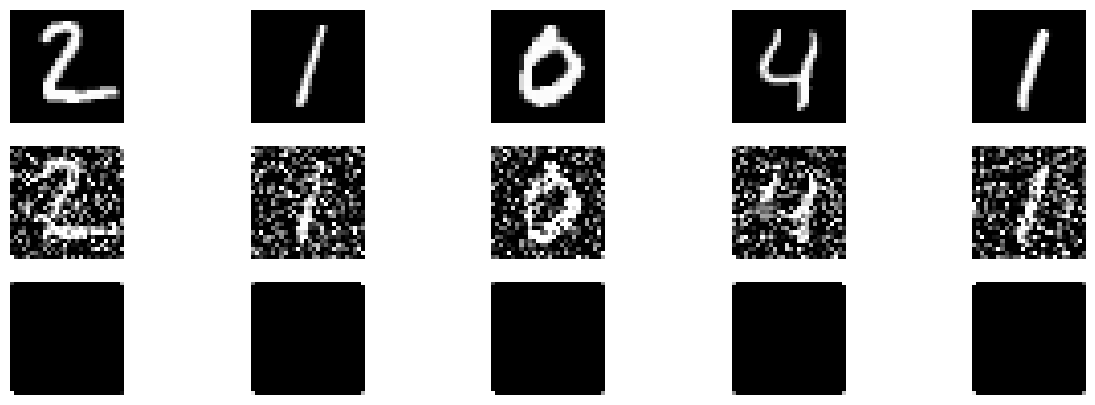

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


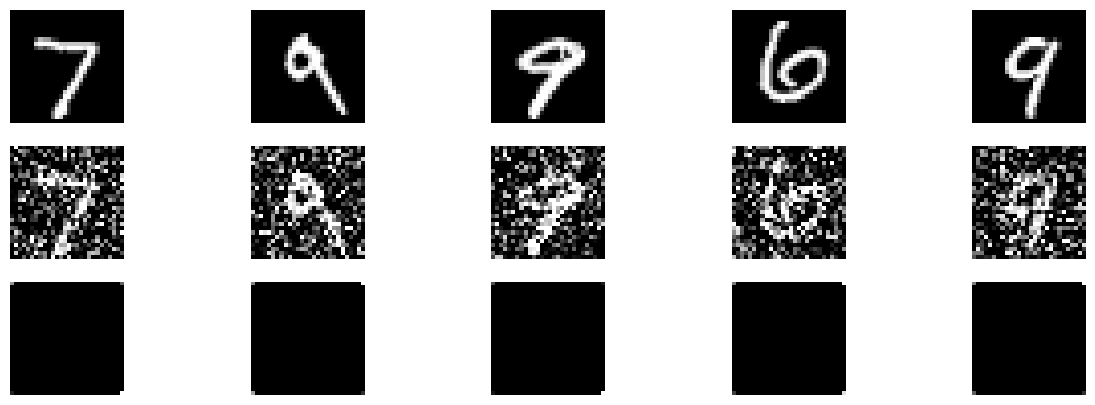

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Load and preprocess MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

# Filter digits
train_images_0_5 = train_images[np.isin(train_labels, range(6))]
test_images_0_5 = test_images[np.isin(test_labels, range(6))]
test_images_6_9 = test_images[np.isin(test_labels, range(6, 10))]

# Add noise
def add_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * np.random.normal(size=images.shape)
    return np.clip(noisy, 0.0, 1.0)

noisy_train = add_noise(train_images_0_5)
noisy_test_0_5 = add_noise(test_images_0_5)
noisy_test_6_9 = add_noise(test_images_6_9)

# Build Convolutional Autoencoder
input_shape = (28, 28, 1)
inputs = layers.Input(shape=input_shape)

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
latent = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(latent)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile model
autoencoder = models.Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')

# Train model
autoencoder.fit(noisy_train[..., np.newaxis], train_images_0_5[..., np.newaxis],
                epochs=10, batch_size=64, validation_split=0.1)

# Evaluate reconstruction
def evaluate_reconstruction(model, noisy, clean):
    reconstructed = model.predict(noisy[..., np.newaxis])
    mse = np.mean((reconstructed - clean[..., np.newaxis]) ** 2)
    mean_ssim = np.mean([
        ssim(clean[i], reconstructed[i, ..., 0], data_range=1.0)
        for i in range(len(clean))
    ])
    return mse, mean_ssim

mse_in, ssim_in = evaluate_reconstruction(autoencoder, noisy_test_0_5, test_images_0_5)
mse_out, ssim_out = evaluate_reconstruction(autoencoder, noisy_test_6_9, test_images_6_9)

print(f"In-distribution MSE: {mse_in:.4f}, SSIM: {ssim_in:.4f}")
print(f"Out-of-distribution MSE: {mse_out:.4f}, SSIM: {ssim_out:.4f}")

# Visualize results
def plot_reconstructions(model, noisy, clean, num_samples=5):
    reconstructed = model.predict(noisy[..., np.newaxis])
    fig, axs = plt.subplots(3, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axs[0, i].imshow(clean[i], cmap='gray')
        axs[1, i].imshow(noisy[i], cmap='gray')
        axs[2, i].imshow(reconstructed[i, ..., 0], cmap='gray')
        for ax in axs[:, i]:
            ax.axis('off')
    axs[0, 0].set_ylabel("Original")
    axs[1, 0].set_ylabel("Noisy")
    axs[2, 0].set_ylabel("Reconstructed")
    plt.show()

plot_reconstructions(autoencoder, noisy_test_0_5, test_images_0_5)
plot_reconstructions(autoencoder, noisy_test_6_9, test_images_6_9)


# 2.Explainable ML

- Build the classified for the fashion MNIST data set
- Use LIME or SHAP to explain the predictions

In [4]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=de54fece70fc8b27ab31a2087d284de83360584a4d24d39b50e8ab70d95da17a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 173kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.12MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 20.6MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training...
Epoch 1/5, Loss: 0.6697
Epoch 2/5, Loss: 0.4475
Epoch 3/5, Loss: 0.4038
Epoch 4/5, Loss: 0.3774
Epoch 5/5, Loss: 0.3595
Accuracy: 86.26%


  0%|          | 0/1000 [00:00<?, ?it/s]

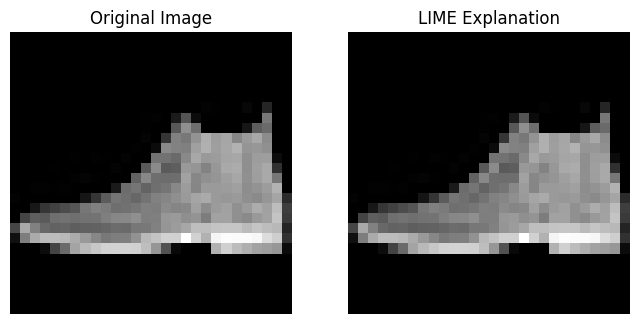

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load Dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Define the Model
class FashionMNISTClassifier(nn.Module):
    def __init__(self):
        super(FashionMNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        # Fully connected layers (flatten size to be set dynamically)
        self.fc1 = None
        self.fc2 = nn.Linear(128, 10)  # Final layer outputs 10 classes

    def set_flatten_size(self, x):
        """Helper to compute the flatten size dynamically"""
        x = self.pool(self.relu(self.conv2(self.relu(self.conv1(x)))))
        self.flatten_size = x.view(x.size(0), -1).size(1)
        self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)

    def forward(self, x):
        if not hasattr(self, 'flatten_size'):  # Ensure dynamic setting of flatten size
            self.set_flatten_size(x)

        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)  # Flatten (using reshape to handle non-contiguous tensors)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 3. Train the Model
model = FashionMNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
print("Training...")
for epoch in range(5):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/5, Loss: {running_loss / len(train_loader):.4f}")

# Evaluate the Model
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")

# 4. LIME Explanation
# Prepare an image for explanation
image, label = test_dataset[0]
image = image.numpy().transpose(1, 2, 0)  # Convert to HWC format for LIME
image_rgb = np.repeat(image, 3, axis=-1)  # Convert grayscale to RGB

# Define a prediction function for LIME
def predict(images):
    """Predict function for LIME, requires numpy array input."""
    # Convert RGB (LIME format) back to grayscale
    images = np.mean(images, axis=-1, keepdims=True)  # Convert to grayscale
    images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    outputs = model(images)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().detach().numpy()

# LIME explainer
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image_rgb, predict, top_labels=1, hide_color=0, num_samples=1000
)

# Get explanation for the top predicted label
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False
)

# Display explanation
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis("off")
plt.show()


In [6]:
!pip


Usage:   
  pip3 <command> [options]

Commands:
  install                     Install packages.
  download                    Download packages.
  uninstall                   Uninstall packages.
  freeze                      Output installed packages in requirements format.
  inspect                     Inspect the python environment.
  list                        List installed packages.
  show                        Show information about installed packages.
  check                       Verify installed packages have compatible dependencies.
  config                      Manage local and global configuration.
  search                      Search PyPI for packages.
  cache                       Inspect and manage pip's wheel cache.
  index                       Inspect information available from package indexes.
  wheel                       Build wheels from your requirements.
  hash                        Compute hashes of package archives.
  completion                  A helper c

In [7]:

import shap


# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load Dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Define the Model
class FashionMNISTClassifier(nn.Module):
    def __init__(self):
        super(FashionMNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        # Fully connected layers (flatten size to be set dynamically)
        self.fc1 = None
        self.fc2 = nn.Linear(128, 10)  # Final layer outputs 10 classes

    def set_flatten_size(self, x):
        """Helper to compute the flatten size dynamically"""
        x = self.pool(self.relu(self.conv2(self.relu(self.conv1(x)))))
        self.flatten_size = x.view(x.size(0), -1).size(1)
        self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)

    def forward(self, x):
        if not hasattr(self, 'flatten_size'):  # Ensure dynamic setting of flatten size
            self.set_flatten_size(x)

        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)  # Flatten (using reshape to handle non-contiguous tensors)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 3. Train the Model
model = FashionMNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
print("Training...")
for epoch in range(5):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/5, Loss: {running_loss / len(train_loader):.4f}")

# Evaluate the Model
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")

# 4. SHAP Explanation
# Prepare a batch of images for SHAP
sample_images, _ = next(iter(test_loader))
sample_images = sample_images.to(device)

# Reshape images to match the model input
sample_images = sample_images[:64]  # Use a small subset as background

# Initialize SHAP explainer
explainer = shap.DeepExplainer(model, sample_images)

# Select one image for explanation
image_to_explain = sample_images[0:1]  # Shape: (1, 1, 28, 28)

# Explain the prediction
shap_values = explainer.shap_values(image_to_explain)

# Visualize SHAP values for each class
shap_values_class = shap_values[0][0].cpu().numpy()  # SHAP values for the first class
original_image = image_to_explain[0][0].cpu().numpy()  # Original grayscale image

# Visualize the SHAP explanation
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(original_image, cmap='gray')
plt.imshow(shap_values_class, cmap='jet', alpha=0.5)  # Overlay SHAP values
plt.title("SHAP Explanation")
plt.axis("off")

plt.show()


Training...
Epoch 1/5, Loss: 0.6616
Epoch 2/5, Loss: 0.4376
Epoch 3/5, Loss: 0.4009
Epoch 4/5, Loss: 0.3779
Epoch 5/5, Loss: 0.3591
Accuracy: 86.52%


RuntimeError: The size of tensor a (28) must match the size of tensor b (128) at non-singleton dimension 3

Training...
Epoch 1/5, Loss: 0.6977
Epoch 2/5, Loss: 0.4734
Epoch 3/5, Loss: 0.4290
Epoch 4/5, Loss: 0.4021
Epoch 5/5, Loss: 0.3804
Accuracy: 84.20%


  0%|          | 0/1000 [00:00<?, ?it/s]

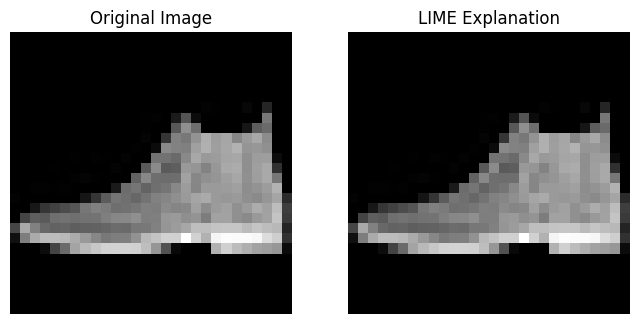

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load Dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Define the Model
class FashionMNISTClassifier(nn.Module):
    def __init__(self):
        super(FashionMNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        # Fully connected layers (flatten size to be set dynamically)
        self.fc1 = None
        self.fc2 = nn.Linear(128, 10)  # Final layer outputs 10 classes

    def set_flatten_size(self, x):
        """Helper to compute the flatten size dynamically"""
        x = self.pool(self.relu(self.conv2(self.relu(self.conv1(x)))))
        self.flatten_size = x.view(x.size(0), -1).size(1)
        self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)

    def forward(self, x):
        if not hasattr(self, 'flatten_size'):  # Ensure dynamic setting of flatten size
            self.set_flatten_size(x)

        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)  # Flatten (using reshape to handle non-contiguous tensors)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 3. Train the Model
model = FashionMNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
print("Training...")
for epoch in range(5):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/5, Loss: {running_loss / len(train_loader):.4f}")

# Evaluate the Model
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")

# 4. LIME Explanation
# Prepare an image for explanation
image, label = test_dataset[0]
image = image.numpy().transpose(1, 2, 0)  # Convert to HWC format for LIME
image_rgb = np.repeat(image, 3, axis=-1)  # Convert grayscale to RGB

# Define a prediction function for LIME
def predict(images):
    """Predict function for LIME, requires numpy array input."""
    # Convert RGB (LIME format) back to grayscale
    images = np.mean(images, axis=-1, keepdims=True)  # Convert to grayscale
    images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    outputs = model(images)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().detach().numpy()

# LIME explainer
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image_rgb, predict, top_labels=1, hide_color=0, num_samples=1000
)

# Get explanation for the top predicted label
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False
)

# Display explanation
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis("off")
plt.show()


# 3.Molecular discovery

- We extract information from QM9 dataset, particularly from each molecule (given orignially in .xyz format) followed by computing features using rdkit and then combine those into a dataframe.
- Link to orginal dataset: http://quantum-machine.org/datasets/
- Link where we can find the functionalities represented by variables in the 'parser' code. For example 'mu' represents the dipole moment. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html

- Adapted from notebook prepared by Ayana Ghosh, research.aghosh@gmail.com

## Install RDkit and Selfies

In [9]:
!pip install rdkit-pypi
!pip install selfies --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 60.0 MB/s eta 0:00:00


In [10]:
import numpy as np
import pandas as pd

import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

import torch
from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize

import selfies as sf

In [11]:
def parse_float(s: str) -> float:
    try:
        return float(s)
    except ValueError:
        base, power = s.split('*^')
        return float(base) * 10**float(power)

def parse_xyz(filename):
    """
    Parses QM9 specific xyz files.
    :param filename: str path to file
    :return:
    """
    num_atoms = 0
    scalar_properties = []
    atomic_symbols = []
    xyz = []
    charges = []
    harmonic_vibrational_frequencies = []
    smiles = ''
    inchi = ''
    with open(filename, 'r') as f:
        for line_num, line in enumerate(f):
            if line_num == 0:
                num_atoms = int(line)
            elif line_num == 1:
                scalar_properties = [float(i) for i in line.split()[2:]]
            elif 2 <= line_num <= 1 + num_atoms:
                atom_symbol, x, y, z, charge = line.split()
                atomic_symbols.append(atom_symbol)
                xyz.append([parse_float(x), parse_float(y), parse_float(z)])
                charges.append(parse_float(charge))
            elif line_num == num_atoms + 2:
                harmonic_vibrational_frequencies = [float(i) for i in line.split()]
            elif line_num == num_atoms + 3:
                smiles = line.split()[0]
            elif line_num == num_atoms + 4:
                inchi = line.split()[0]

    result = {
        'num_atoms': num_atoms,
        'atomic_symbols': atomic_symbols,
        'pos': torch.tensor(xyz),
        'charges': np.array(charges),
        'harmonic_oscillator_frequencies': harmonic_vibrational_frequencies,
        'smiles': smiles,
        'inchi': inchi
    }
    scalar_property_labels = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u', 'h', 'g', 'cv']
    scalar_properties = dict(zip(scalar_property_labels, scalar_properties))
    result.update(scalar_properties)
    return result

## Download the data

Generate lists of SMILE strings and append with properties that we can directly retrieve from the QM9 dataset

In [12]:
!gdown https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF

Downloading...
From (original): https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF
From (redirected): https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF&confirm=t&uuid=f0dd689d-f4e1-4773-9ce1-74288fa6d6c3
To: /content/dsgdb9nsd.xyz.tar.bz2
100% 86.1M/86.1M [00:01<00:00, 43.8MB/s]


What are SMILES and when were they invented (note that ChatGPT is unlikely to produce the correct citation - so Wikipedia can help)?

Answer: SMILES (Simplified Molecular Input Line Entry System) is a compact, human-readable notation for representing chemical structures as strings, widely used in cheminformatics and machine learning. Invented by David Weininger in the 1980s, it gained popularity for its simplicity and integration into cheminformatics tools.

In [13]:
!mkdir /content/Molecules
!tar -C Molecules -xvf /content/dsgdb9nsd.xyz.tar.bz2

Streaming output truncated to the last 5000 lines.
dsgdb9nsd_128886.xyz
dsgdb9nsd_128887.xyz
dsgdb9nsd_128888.xyz
dsgdb9nsd_128889.xyz
dsgdb9nsd_128890.xyz
dsgdb9nsd_128891.xyz
dsgdb9nsd_128892.xyz
dsgdb9nsd_128893.xyz
dsgdb9nsd_128894.xyz
dsgdb9nsd_128895.xyz
dsgdb9nsd_128896.xyz
dsgdb9nsd_128897.xyz
dsgdb9nsd_128898.xyz
dsgdb9nsd_128899.xyz
dsgdb9nsd_128900.xyz
dsgdb9nsd_128901.xyz
dsgdb9nsd_128902.xyz
dsgdb9nsd_128903.xyz
dsgdb9nsd_128904.xyz
dsgdb9nsd_128905.xyz
dsgdb9nsd_128906.xyz
dsgdb9nsd_128907.xyz
dsgdb9nsd_128908.xyz
dsgdb9nsd_128909.xyz
dsgdb9nsd_128910.xyz
dsgdb9nsd_128911.xyz
dsgdb9nsd_128912.xyz
dsgdb9nsd_128913.xyz
dsgdb9nsd_128914.xyz
dsgdb9nsd_128915.xyz
dsgdb9nsd_128916.xyz
dsgdb9nsd_128917.xyz
dsgdb9nsd_128918.xyz
dsgdb9nsd_128919.xyz
dsgdb9nsd_128920.xyz
dsgdb9nsd_128921.xyz
dsgdb9nsd_128922.xyz
dsgdb9nsd_128923.xyz
dsgdb9nsd_128924.xyz
dsgdb9nsd_128925.xyz
dsgdb9nsd_128926.xyz
dsgdb9nsd_128927.xyz
dsgdb9nsd_128928.xyz
dsgdb9nsd_128929.xyz
dsgdb9nsd_128930.xyz
dsgd

In [14]:
smiles = []
enthalpy = []
u0 = []
u = []
g = []
alpha = []
r2 = []
mu = []

#may need to change the path
filenames = glob.glob('/content/Molecules/*.xyz')

#may need to go through the full range
for fid in range(5000):
    x = parse_xyz(filenames[fid])
    smiles_loc = x['smiles']
    enthalpy_loc = x['h']
    dipole_moment = x['mu']
    homo_loc = x['homo']
    lumo_loc = x['lumo']
    gap_loc = x['gap']
    zpve_loc = x['zpve']
    u0_loc = x['u0']
    u_loc = x['u']
    g_loc = x['g']
    alpha_loc = x['alpha']
    r2_loc = x['r2']
    smiles.append(smiles_loc)
    mu.append(dipole_moment)
    enthalpy.append(enthalpy_loc)
    u0.append(u0_loc)
    u.append(u_loc)
    g.append(g_loc)
    alpha.append(alpha_loc)
    r2.append(r2_loc)

Let's compute few basic features and put together a dataset. Features we compute:
- molecular weight,
- topological polar surface area,
- molar log P,
- number of hydrogen bond donors,
- acceptors,
- valence electrons,
- maximum partial charge,
- minimum partial charge,
- number of rotatable bonds,
- number of ring counts,
- number of stereocenters

In [15]:
mol_wt, tpsa, logp_ml, hbd, hba  = [], [], [], [], []
vale, partialcg_max, partialcg_min, rotbd, ringct, stereoct = [], [], [], [], [], []

for i in range(len(smiles)):
    m = Chem.MolFromSmiles(smiles[i])
    mol_wt_l = Descriptors.ExactMolWt(m)
    tpsa_l, logp_l = Descriptors.TPSA(m), Descriptors.MolLogP(m)
    hbd_l, hba_l = Descriptors.NumHDonors(m), Descriptors.NumHAcceptors(m)
    vale_l = Descriptors.NumValenceElectrons(m),
    partialcharge_max_l, partialcharge_min_l = Descriptors.MaxPartialCharge(m), Descriptors.MinPartialCharge(m)
    rotbd_l = Descriptors.NumRotatableBonds(m)
    ring_ct, stereo_cent = Descriptors.RingCount(m), rdMolDescriptors.CalcNumAtomStereoCenters(m)

    mol_wt.append(mol_wt_l)
    tpsa.append(tpsa_l)
    logp_ml.append(logp_l)
    hbd.append(hbd_l)
    hba.append(hba_l)
    vale.append(vale_l)
    partialcg_max.append(partialcharge_max_l)
    partialcg_min.append(partialcharge_min_l)
    rotbd.append(rotbd_l)
    ringct.append(ring_ct)
    stereoct.append(stereo_cent)

New dataset with few features with SMILE strings

In [16]:
df = pd.DataFrame({'smiles': smiles, 'mole_logp': logp_ml,'tpsa': tpsa, 'mol_wt' : mol_wt,
                   'hbd': hbd, 'hba':hba, 'valencee':vale, 'max_partialcharge':partialcg_max, 'min_partialcharge':partialcg_min,
                   'rotatablebd':rotbd, 'ringct':ringct, 'stereocent': stereoct, 'dipole_moment':mu})

In [17]:
df

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment
0,COC1CC1NC=O,-0.48030,38.33,115.063329,1,2,"(46,)",0.206930,-0.379239,3,1,2,3.4391
1,CCN1C2C3C(O)C2C13,-0.32040,23.47,125.084064,1,2,"(50,)",0.065648,-0.392301,1,5,0,2.1807
2,CC(=NO)C1(CC1)C#C,1.24990,32.59,123.068414,1,2,"(48,)",0.072387,-0.410869,1,1,0,0.4984
3,CCN(CC(N)=O)C=O,-1.05000,63.40,130.074228,1,2,"(52,)",0.236536,-0.368134,4,0,0,2.5158
4,NC1=NC(=N)N=NO1,-1.47373,101.68,113.033760,2,6,"(42,)",0.321808,-0.351152,0,1,0,2.3363
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,CC#CC1(O)CC2OC12,-0.08810,32.76,124.052429,1,2,"(48,)",0.156020,-0.374630,0,2,3,1.3762
4996,CCOC1CN(C1)C=O,-0.13650,29.54,129.078979,0,2,"(52,)",0.209386,-0.374813,3,1,0,4.9598
4997,COC(C#C)C1CC1C,1.29060,9.23,124.088815,0,1,"(50,)",0.120150,-0.368471,2,1,3,0.9262
4998,O=C1CC2(O1)C1CC2C1,0.71190,26.30,124.052429,0,2,"(48,)",0.309963,-0.457733,0,4,0,4.2155


## Convert SMILEs to SELFIEs

As an excercise, read the SELFIES paper (https://github.com/aspuru-guzik-group/selfies) and describe the difference between SMILES and SELFIEs

Answer:
Comparison Between SMILES and SELFIES

SMILES and SELFIES (Self-referencing Embedded Strings) are both string-based notations used to represent chemical structures. While SMILES is widely used, SELFIES is a newer system designed to address some of SMILES' limitations. Here’s a detailed comparison of the two:

**Validity of Strings:**

SMILES strings can sometimes be invalid, meaning they might not correspond to any real molecule. This makes manual and computational validation necessary before using the data.
SELFIES, on the other hand, guarantees that every string represents a valid molecule. This feature eliminates the need for additional validation and ensures consistency.
Handling Mutations:

In SMILES, mutations (changes) to the string often result in invalid or non-chemical representations. This limits its robustness for applications like generative machine learning.
SELFIES is mutation-resistant; even random changes in the string produce valid chemical structures, which is particularly beneficial for data augmentation and generative tasks.
Representation of Molecular Features:

SMILES uses a non-local representation, requiring additional syntax and rules to handle rings and branches. For instance, it uses numbers to denote ring closures and parentheses for branching, which can be challenging to process algorithmically.
SELFIES adopts a local representation, simplifying the encoding of rings, branches, and other molecular features. This makes it more intuitive and easier to parse by both humans and machines.
Suitability for Machine Learning:

SMILES often requires preprocessing, such as canonicalization or validation, before being used in machine learning models. Without such steps, issues like invalid molecules or duplicate representations can arise.
SELFIES, being inherently valid and consistent, is directly usable in machine learning workflows. This eliminates preprocessing overhead and makes it particularly attractive for training models.
Handling Complexity:

SMILES can be problematic with large or complex molecules, as the representation becomes unwieldy and error-prone.
SELFIES is designed to scale efficiently, handling larger molecules and diverse chemical graphs without compromising validity or readability.

In [18]:
smiles

['COC1CC1NC=O',
 'CCN1C2C3C(O)C2C13',
 'CC(=NO)C1(CC1)C#C',
 'CCN(CC(N)=O)C=O',
 'NC1=NC(=N)N=NO1',
 'OC1C2CCCC1C=C2',
 'CC1(C)C2OC1(C)C2O',
 'CCC1(CN=CO1)C#N',
 'CN1C=NC(=N)C=C1O',
 'CN1C=NNC1=O',
 'CC12CC(O)C1(O2)C#C',
 'OC1CNC2=CON=C12',
 'CCC1(C)OC2CC12',
 'CC(=O)C1COC=NC1',
 'N=C1NC2=C(OC=C2)O1',
 'CC1C(O)C1C#N',
 'ON=C1C2CC2CC1O',
 'CC1C2CC(=O)NC12C',
 'CCN1C=NC(O)=C1O',
 'OC1=CC=NC=C1F',
 'CC1C=CC2(CC12)C#C',
 'OC1CC11C2CC2C1O',
 'CCOC(=O)C(C)CC',
 'C#CC#CC1C2CC1C2',
 'CC1(O)CC(=N)OC1=O',
 'CC1CC2CN2C(=O)C1',
 'N=COCCNC=O',
 'NC(=[NH2+])C1=CC(=O)N[CH-]1',
 'CC1(O)CC(O)CC1=O',
 'NC1=NC2C(O1)C2C=O',
 'CC1OC(=N)C1(N)C#C',
 'CCCC1CC(=O)C1C',
 'C1CC11CC2(CN2)CO1',
 'CCC12NC1(C)CC2O',
 'C#CCCC1CCC1',
 'CC(C)(C#N)C#CCO',
 'COC1(C)C(C)CC1C',
 'NC1=CNC=C1N(=O)=O',
 'CCC12C(C)C1N1CC21',
 'NC1=CC(O)=NOC1=N',
 'CC(O)C#CC(O)C=O',
 'CC#CC1CC1CO',
 'CC(=O)C1C2CC1O2',
 'O=C1NCC=CC2OC12',
 'CC1=C(C)C(=O)C(O)C1',
 'CC1=C(O)C(O)=CC=N1',
 'CC1CN1CC1(O)CC1',
 'N#CC1=CN=NC=N1',
 'CCC1=NN=C(CC)O1',
 '

The SELFIES have some limitations on acceptable bonding. So we refine the data set to remove the molecules that do not fit into supported semantic constraints.

In [19]:
selfies_dataset = []
error_smiles = []

for i in range(len(smiles)):
    try:
        local_sf = sf.encoder(smiles[i])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        error_smiles.append(smiles[i])  # Store the SMILES string that caused the error
        continue  # Skip to the next iteration

Error encoding SMILES at index 37: input violates the currently-set semantic constraints
	SMILES: NC1=CNC=C1N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 308: input violates the currently-set semantic constraints
	SMILES: CC1=C(ON=N1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 389: input violates the currently-set semantic constraints
	SMILES: NC1=CC(=NO1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 567: input violates the currently-set semantic constraints
	SMILES: NC1=C(C=NN1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 1994: input violates the currently-set semantic constraints
	SMILES: CC1=C(C=NN1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 2818: input violates the currently-set semanti

Let's see what these molecules are....

In [20]:
error_smiles_set = set(error_smiles)
error_smiles_set

{'CC1=C(C=NN1)N(=O)=O',
 'CC1=C(ON=N1)N(=O)=O',
 'CC1=NNN=C1N(=O)=O',
 'N=C1ON=C(O1)N(=O)=O',
 'NC1=C(C=NN1)N(=O)=O',
 'NC1=C(ON=C1)N(=O)=O',
 'NC1=CC(=NO1)N(=O)=O',
 'NC1=CNC=C1N(=O)=O',
 'O=N(=O)C1=NC=CO1',
 'OC1=NNC=C1N(=O)=O'}

... how many of them are there

In [21]:
df['smiles'].isin(error_smiles_set).sum()

10

And remove them from the dataframe

In [22]:
df_filtered = df[~df['smiles'].isin(error_smiles_set)]
df_filtered.tail(5)

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment
4995,CC#CC1(O)CC2OC12,-0.0881,32.76,124.052429,1,2,"(48,)",0.156020,-0.374630,0,2,3,1.3762
4996,CCOC1CN(C1)C=O,-0.1365,29.54,129.078979,0,2,"(52,)",0.209386,-0.374813,3,1,0,4.9598
4997,COC(C#C)C1CC1C,1.2906,9.23,124.088815,0,1,"(50,)",0.120150,-0.368471,2,1,3,0.9262
4998,O=C1CC2(O1)C1CC2C1,0.7119,26.30,124.052429,0,2,"(48,)",0.309963,-0.457733,0,4,0,4.2155
4999,O=CNCCCC#C,0.1458,29.10,111.068414,1,1,"(44,)",0.206623,-0.358645,4,0,0,3.4309


Now, let's generate one-hot encodings.

In [23]:
#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

np.array(one_hot_vectors).shape

(4990, 21, 27)

Explore the code segment above. What is:
- alphabet
- symbol_to_idx
- what are the dimensionalities of the np.array(one_hot_vectors).shape

Alphabet:

The alphabet represents the set of unique symbols present in the SELFIES dataset. It includes special symbols such as [nop], which stands for "no operation" and is often used for padding or maintaining consistent string lengths.
Dimensionality: The size of the alphabet is determined by the total number of unique symbols, denoted as len(alphabet). For example, if the alphabet contains 30 symbols, len(alphabet) = 30.
Symbol-to-Index Mapping:

This refers to a dictionary that maps each symbol in the alphabet to a unique integer index. This mapping is essential for converting symbolic data into numerical form, which is required for machine learning models.
Dimensionality: The number of entries in the dictionary corresponds to the size of the alphabet, len(symbol_to_idx). For instance, if the alphabet has 30 symbols, the dictionary will have 30 key-value pairs.
One-Hot Encoding Array:

One-hot encoding is a technique used to represent categorical data numerically. For SELFIES strings, each symbol in a string is converted into a vector where only one element (corresponding to the symbol's index) is 1, and the rest are 0.
Dimensionality: The shape of the one-hot encoding array is defined as (N, L, A), where:
N is the number of SELFIES strings (e.g., 100).
L is the maximum length of the strings after padding (e.g., 50).
A is the size of the alphabet (e.g., 30).
For example, if there are 100 strings, each padded to a maximum length of 50, and the alphabet has 30 symbols, the array shape will be (100, 50, 30)

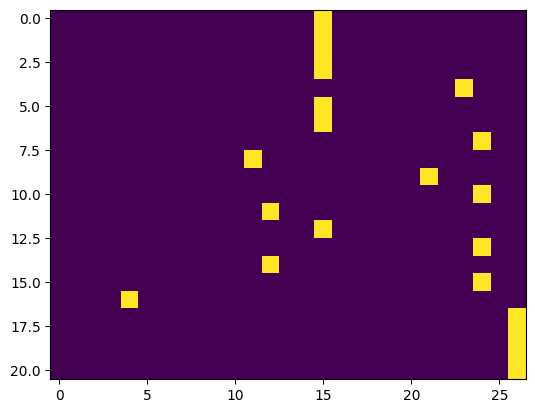

In [24]:
plt.imshow(np.array(one_hot_vectors)[310,:,:])

Now, let's explore the properties of the latent space of this dataset. Using ChaGPT:
- Write the AE using the encoded smiles as an input with 2D latent space
-  Visualize the latent distribution and representation
- Experiment with difefrent attributes from data frame as labels, and see how they are distirbuted in latent space

Epoch 1/50, Loss: 0.0812
Epoch 2/50, Loss: 0.0204
Epoch 3/50, Loss: 0.0202
Epoch 4/50, Loss: 0.0202
Epoch 5/50, Loss: 0.0199
Epoch 6/50, Loss: 0.0184
Epoch 7/50, Loss: 0.0174
Epoch 8/50, Loss: 0.0171
Epoch 9/50, Loss: 0.0169
Epoch 10/50, Loss: 0.0168
Epoch 11/50, Loss: 0.0166
Epoch 12/50, Loss: 0.0164
Epoch 13/50, Loss: 0.0162
Epoch 14/50, Loss: 0.0160
Epoch 15/50, Loss: 0.0158
Epoch 16/50, Loss: 0.0158
Epoch 17/50, Loss: 0.0157
Epoch 18/50, Loss: 0.0156
Epoch 19/50, Loss: 0.0156
Epoch 20/50, Loss: 0.0155
Epoch 21/50, Loss: 0.0155
Epoch 22/50, Loss: 0.0154
Epoch 23/50, Loss: 0.0154
Epoch 24/50, Loss: 0.0153
Epoch 25/50, Loss: 0.0153
Epoch 26/50, Loss: 0.0152
Epoch 27/50, Loss: 0.0152
Epoch 28/50, Loss: 0.0152
Epoch 29/50, Loss: 0.0151
Epoch 30/50, Loss: 0.0151
Epoch 31/50, Loss: 0.0151
Epoch 32/50, Loss: 0.0150
Epoch 33/50, Loss: 0.0150
Epoch 34/50, Loss: 0.0150
Epoch 35/50, Loss: 0.0150
Epoch 36/50, Loss: 0.0149
Epoch 37/50, Loss: 0.0149
Epoch 38/50, Loss: 0.0149
Epoch 39/50, Loss: 0.

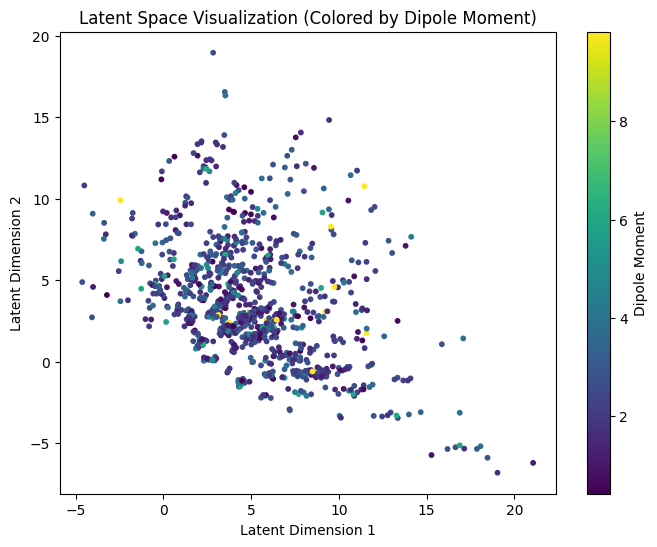

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define the Autoencoder
class AE2D(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super(AE2D, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed
# Normalize one-hot vectors for model input
one_hot_vectors = np.array(one_hot_vectors)
input_data = torch.tensor(one_hot_vectors, dtype=torch.float32)

# Split into training and testing sets
train_size = int(0.8 * len(input_data))
test_size = len(input_data) - train_size
train_data, test_data = torch.utils.data.random_split(input_data, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
# Initialize model, loss function, and optimizer
input_dim = input_data.shape[1] * input_data.shape[2]  # Flattened input dimension
model = AE2D(input_dim=input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.view(batch.size(0), -1)  # Flatten input
        optimizer.zero_grad()
        z, reconstructed = model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")
# Extract latent representations
model.eval()
latents = []
labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.view(batch.size(0), -1)
        z, _ = model(batch)
        latents.append(z)
        labels.extend(df_filtered['dipole_moment'][:len(batch)])  # Example label: dipole moment

latents = torch.cat(latents).numpy()
labels = np.array(labels)

# Plot latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar(scatter, label='Dipole Moment')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization (Colored by Dipole Moment)')
plt.show()

Do the same with the VAE, also with 2D latent space

Epoch 1/50, Loss: 2914.5129
Epoch 2/50, Loss: 737.0440
Epoch 3/50, Loss: 717.2266
Epoch 4/50, Loss: 710.9018
Epoch 5/50, Loss: 707.8298
Epoch 6/50, Loss: 705.8582
Epoch 7/50, Loss: 704.0716
Epoch 8/50, Loss: 703.7553
Epoch 9/50, Loss: 702.6493
Epoch 10/50, Loss: 701.6944
Epoch 11/50, Loss: 701.6075
Epoch 12/50, Loss: 701.0601
Epoch 13/50, Loss: 700.6118
Epoch 14/50, Loss: 700.4274
Epoch 15/50, Loss: 700.3803
Epoch 16/50, Loss: 700.4480
Epoch 17/50, Loss: 700.4148
Epoch 18/50, Loss: 700.0311
Epoch 19/50, Loss: 699.4343
Epoch 20/50, Loss: 699.5434
Epoch 21/50, Loss: 697.5753
Epoch 22/50, Loss: 695.3432
Epoch 23/50, Loss: 694.6351
Epoch 24/50, Loss: 693.8281
Epoch 25/50, Loss: 692.3988
Epoch 26/50, Loss: 692.7374
Epoch 27/50, Loss: 692.0885
Epoch 28/50, Loss: 692.5883
Epoch 29/50, Loss: 691.7019
Epoch 30/50, Loss: 690.6599
Epoch 31/50, Loss: 689.8946
Epoch 32/50, Loss: 690.4978
Epoch 33/50, Loss: 689.4315
Epoch 34/50, Loss: 690.3087
Epoch 35/50, Loss: 690.4704
Epoch 36/50, Loss: 689.3732


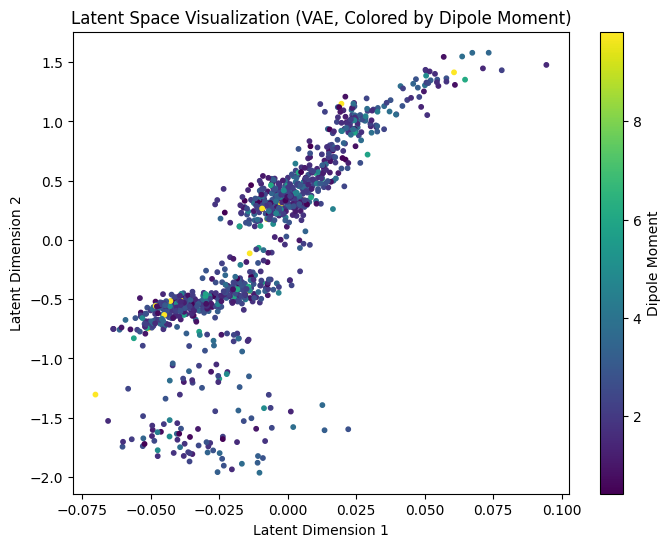

In [26]:
class VAE2D(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super(VAE2D, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.mu_layer = nn.Linear(64, latent_dim)
        self.logvar_layer = nn.Linear(64, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return z, x_reconstructed, mu, logvar
# Normalize and flatten the one-hot vectors
input_data = torch.tensor(one_hot_vectors, dtype=torch.float32)
train_size = int(0.8 * len(input_data))
test_size = len(input_data) - train_size
train_data, test_data = torch.utils.data.random_split(input_data, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

def vae_loss(reconstructed, x, mu, logvar):
    reconstruction_loss = nn.functional.mse_loss(reconstructed, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

input_dim = input_data.shape[1] * input_data.shape[2]
model = VAE2D(input_dim=input_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.view(batch.size(0), -1)  # Flatten input
        optimizer.zero_grad()
        z, reconstructed, mu, logvar = model(batch)
        loss = vae_loss(reconstructed, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

model.eval()
latents = []
labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.view(batch.size(0), -1)
        z, _, mu, _ = model(batch)
        latents.append(mu)
        labels.extend(df_filtered['dipole_moment'][:len(batch)])  # Example label: dipole moment

latents = torch.cat(latents).numpy()
labels = np.array(labels)

# Plot latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar(scatter, label='Dipole Moment')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization (VAE, Colored by Dipole Moment)')
plt.show()

Write the VAE with the 10D latent space. Suggest an approach to visualize the latent space

In [27]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

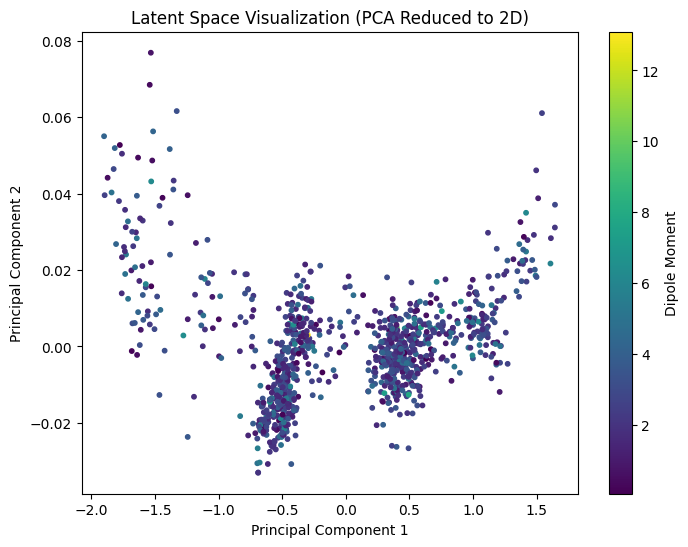

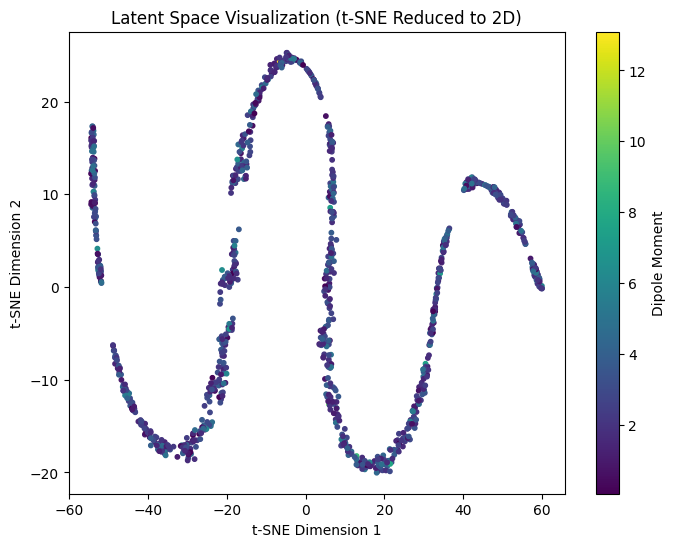

In [28]:
class VAE10D(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE10D, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
        )
        self.mu_layer = nn.Linear(128, latent_dim)
        self.logvar_layer = nn.Linear(128, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return z, x_reconstructed, mu, logvar



# Collect latent representations
model.eval()
latents = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.view(batch.size(0), -1)
        z, _, mu, _ = model(batch)
        latents.append(mu)

latents = torch.cat(latents).numpy()

# Apply PCA
pca = PCA(n_components=2)
latents_pca = pca.fit_transform(latents)

# Plot PCA result
plt.figure(figsize=(8, 6))
plt.scatter(latents_pca[:, 0], latents_pca[:, 1], s=10, c=df_filtered['dipole_moment'][:len(latents)], cmap='viridis')
plt.colorbar(label='Dipole Moment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Latent Space Visualization (PCA Reduced to 2D)')
plt.show()



# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latents_tsne = tsne.fit_transform(latents)

# Plot t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(latents_tsne[:, 0], latents_tsne[:, 1], s=10, c=df_filtered['dipole_moment'][:len(latents)], cmap='viridis')
plt.colorbar(label='Dipole Moment')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Latent Space Visualization (t-SNE Reduced to 2D)')
plt.show()


t-SNE is better for capturing local structures in the data but may lose global relationships. It works well for clustered data.

Describe the difference between AE and VAE latent distirbutions

Answer:
Mapping:

Autoencoder (AE): Performs a deterministic mapping from the input data to a latent vector. Each input always maps to a fixed point in the latent space.
Variational Autoencoder (VAE): Uses a probabilistic approach, mapping inputs to distributions defined by a mean and variance. This allows for sampling and uncertainty modeling.
Latent Space Structure:

AE: The latent space is sparse and lacks structure. It doesn't ensure smooth transitions or meaningful organization.
VAE: Latent space is continuous, smooth, and organized. This structured latent space is crucial for generating coherent outputs during sampling.
Regularization:

AE: Regularization is optional or absent. There is no specific constraint on the latent space distribution.
VAE: Includes KL divergence regularization, which enforces the latent space to follow a Gaussian prior. This ensures that the latent space is well-defined for generative tasks.
Reconstruction Quality:

AE: Typically provides higher reconstruction accuracy since it focuses entirely on minimizing reconstruction loss.
VAE: Reconstruction quality may be slightly worse due to the regularization imposed on the latent space.
Generative Capability:

AE: Limited generative ability due to its unstructured latent space. Sampling from this space often leads to incoherent outputs.
VAE: Strong generative capabilities, as the well-defined latent space allows meaningful sampling and interpolation between data points.
Interpolation:

AE: Interpolation in latent space is unreliable and often produces unrealistic results.
VAE: Reliable and meaningful interpolation due to the continuous and smooth structure of the latent space

Explore the variability of
- dipole momentum,
- number of rings
- mole log P over latent spaces.
What conclusions can you make?

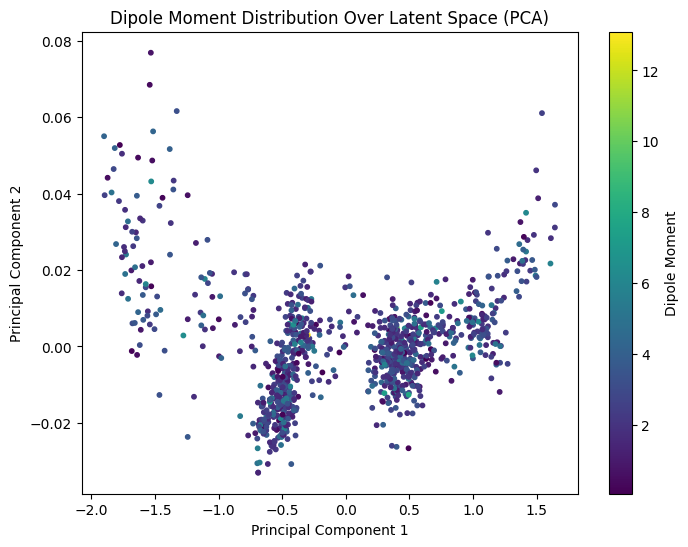

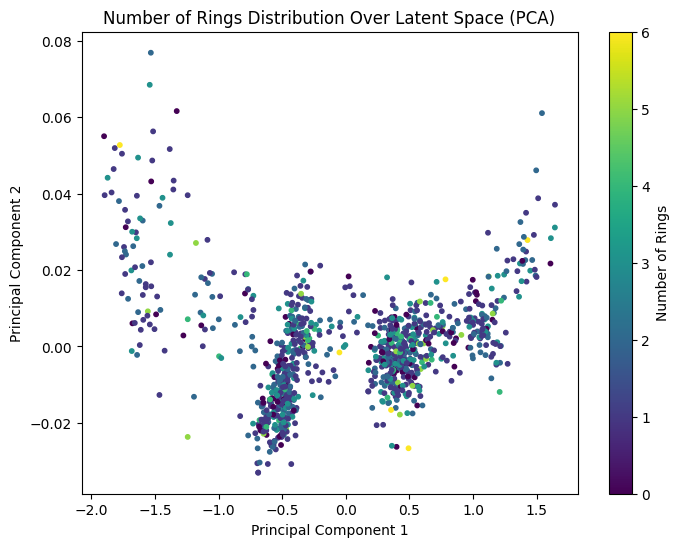

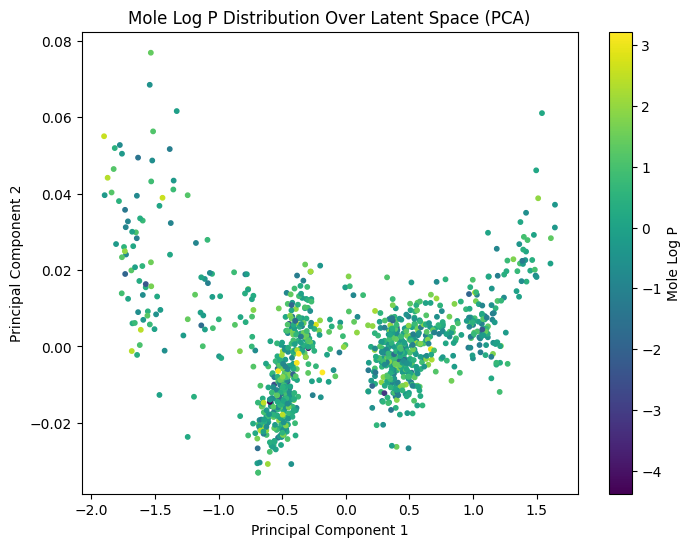

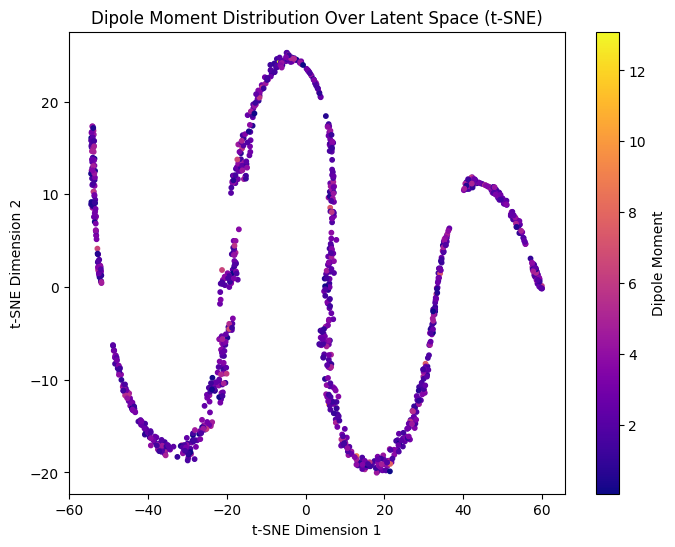

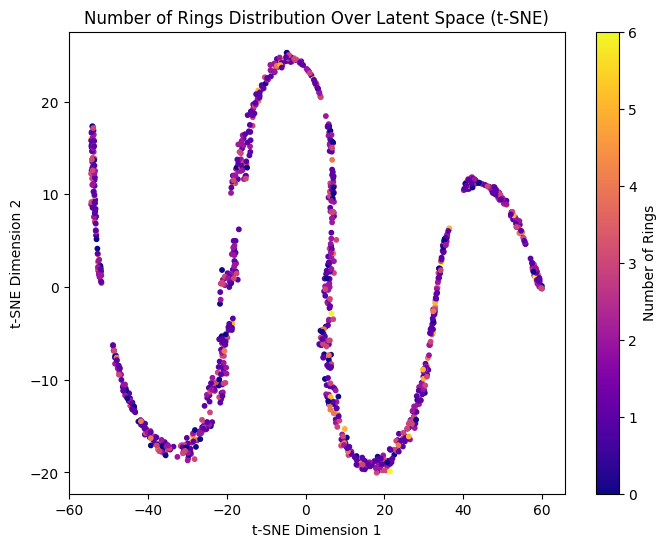

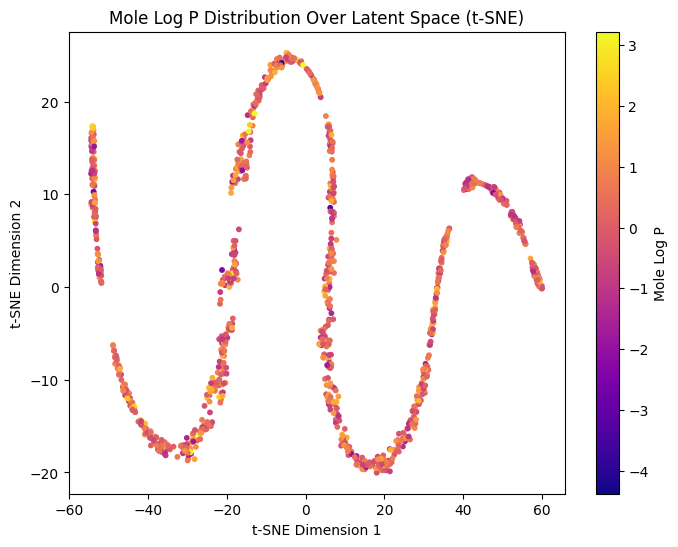

In [30]:
# Collect latent representations and associated molecular properties
model.eval()
latents = []
properties = []

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        batch_data = batch.view(batch.size(0), -1)
        z, _, mu, _ = model(batch_data)
        latents.append(mu)
        properties.append(df_filtered.iloc[batch_idx * batch.size(0): (batch_idx + 1) * batch.size(0)][['dipole_moment', 'ringct', 'mole_logp']].values)

# Combine latent space and properties
latents = torch.cat(latents).numpy()
properties = np.vstack(properties)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce latent space to 2D
pca = PCA(n_components=2)
latents_pca = pca.fit_transform(latents)

# Properties for visualization
property_names = ['Dipole Moment', 'Number of Rings', 'Mole Log P']
property_columns = ['dipole_moment', 'ringct', 'mole_logp']

# Plot each property over latent space
for i, property_name in enumerate(property_names):
    plt.figure(figsize=(8, 6))
    plt.scatter(latents_pca[:, 0], latents_pca[:, 1], c=properties[:, i], cmap='viridis', s=10)
    plt.colorbar(label=property_name)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'{property_name} Distribution Over Latent Space (PCA)')
    plt.show()

from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latents_tsne = tsne.fit_transform(latents)

# Plot each property over latent space
for i, property_name in enumerate(property_names):
    plt.figure(figsize=(8, 6))
    plt.scatter(latents_tsne[:, 0], latents_tsne[:, 1], c=properties[:, i], cmap='plasma', s=10)
    plt.colorbar(label=property_name)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(f'{property_name} Distribution Over Latent Space (t-SNE)')
    plt.show()


Property Clustering: If distinct clusters appear for a property, it indicates that the VAE latent space captures relevant molecular features effectively.
Smooth Gradients: Smooth transitions in property values (e.g., from low to high dipole moment) suggest that the latent space maintains a structured, interpretable relationship with these properties.
Overlaps: Overlaps of property distributions (e.g., high dipole moments for various numbers of rings) might reveal interactions or correlations between properties.